# Energy and time Predictions for the kinarm reaching model. 

In the following code we create a kinarm model and perform optimizations to find the trajectories and movement times for reaches of different distances, and different valuations of time.

if you set 'theGeneratePlots=1', you will get 6 plots per optimization.


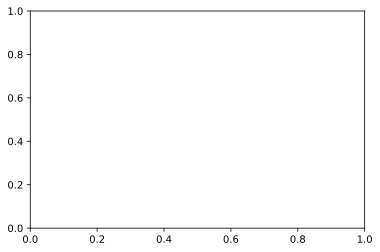

In [1]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import ReachingModels as reaching
import numpy as np
import matplotlib.pyplot as plt
import colour as clr
import plotpresentlib as pp
from matplotlib.figure import Figure

DOSAVE = 0
savename = 'out50_fill'
loopdist = np.linspace(0.01,0.5,num=50)
loopValuation = np.concatenate((np.array([.05,0.08,0.1,.25,.5,.75]),np.linspace(1,50,num=50),np.array([100,150,200,250,300,350,400, 450, 500])))

loopdist = np.array([0.1])
loopValuation = np.array([10])

%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(0,'parameterFiles')

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = reaching.Kinarm()
sim.l1 = 0.35
sim.l = [sim.l1,sim.l2]
#sim = reaching.PointMass()

# starting x and y
x = 0.0
ys = 0.25
xystart = np.array([x,ys])



In [2]:

# create color gradient tvalcolors.
color1 = clr.Color("#e0f3db")
tvalcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))

### allocate for storage:durations, speeds, costs, rewards, solved
M = len(loopValuation)
N = len(loopdist)
duration      = np.zeros([M, N])
peakhandspeed = np.zeros([M, N])
J             = np.zeros([M, N])
costFR        = np.zeros([M, N])
costWork      = np.zeros([M, N])
costTime      = np.zeros([M, N])
solved        = np.zeros([M, N])
distance      = np.zeros([M, N])
timeValuation = np.zeros([M, N])

# initialize trajectories as a 1d list of 1d lists. 
traj = [[0 for x in range(N)] for y in range(M)] 

### SETUP
optiPrev = sim.movementTimeOptSetup(
  theTimeValuation  = 1.0,
  theN              = 60,   #2022-10: 20 and 40 both work flawlessly. this is after removing accel = 0 constraint. 
  theFRCoef         = 0.085)

### SOLVE
trajOrig, optiOrig = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]),
  theDurationGuess    = 1,
  theTimeValuation    = 1,
  theGeneratePlots    = 0)

dGuess = trajOrig.duration

#


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3392
Number of nonzeros in inequality constraint Jacobian.:     1404
Number of nonzeros in Lagrangian Hessian.............:     1518

Total number of variables............................:     1099
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [3]:
trajOrig.solved
#fig, ax = plt.subplots()
#ax.plot(trajOrig.time,trajOrig.vecspeed)


False

In [ ]:
for (nDist, valdist) in enumerate(loopdist):  
  for (mVal, valtval) in enumerate(loopValuation):
    trajResult, optiReturn = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([0,valdist]), 
      theDurationGuess  = dGuess,
      theTimeValuation    = valtval,
      theGeneratePlots    = 0)
    
    # if we found a solution:
    if trajResult.solved:
      # unpack the results
      duration[mVal,nDist]      = trajResult.duration
      J[mVal,nDist]             = trajResult.costJ
      costFR[mVal,nDist]        = trajResult.costFR
      costWork[mVal,nDist]      = trajResult.costWork
      costTime[mVal,nDist]      = trajResult.costTime
      peakhandspeed[mVal,nDist] = trajResult.peakhandspeed
      solved[mVal,nDist]        = trajResult.solved
      distance[mVal,nDist]     = valdist
      timeValuation[mVal,nDist] = valtval
      # update the optiPrev, only if solved == true.
      #optiPrev  = optiReturn
      dGuess    = trajResult.duration
      traj[mVal][nDist]=trajResult
    
    #increment inner
# %%

if DOSAVE:
  saveDict = {
    "duration":duration,
    "peakspeed":peakhandspeed,
    "distance":distance,
    "timeValuation":timeValuation,
    "traj":traj}
  import scipy
  scipy.io.savemat('simulationResults/'+savename+'.mat', saveDict)


In [ ]:

#%% Figure 1: duration / distance 

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = duration.copy()
  y = y[v,:]
  y = y.T
  ytemp = np.concatenate(([0],y))
  
  xtemp = np.concatenate(([0],xtemp))
  inds = ytemp !=0
  plt.plot(xtemp,ytemp,label=loopValuation[v],color = tvalcolors[v].get_hex())

plt.legend()
# %%
plt.xlabel("Distance (m)")
plt.ylabel("Movement duration (s)")
ax.set_ylim(0,2)
pp.figurefyTalk()


In [ ]:
b= traj[1][1]
b.time

In [ ]:
#%% Figure 2: distance peak speed / distance
f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = peakhandspeed.copy()
  y = y[v,:]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = tvalcolors[v].get_hex())
  plt.xlabel("Distance (m)")
  plt.ylabel("Peak hand speed (m/s)")
  plt.legend()

pp.figurefyTalk()
# %%

In [ ]:
from matplotlib import cm
cColor = cm.get_cmap('viridis')#viridis

plt.contourf(distance,duration, timeValuation,levels=np.linspace(0,150,16),cmap =cColor) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Distance (m)',fontsize = 28)
plt.ylabel('Duration (s)',fontsize = 28)
plt.colorbar()

In [ ]:
# plt.contourf(distances,peakhandspeed, timeValuation,levels=np.linspace(0,150,16)) #,cmap=jet.reversed() 
plt.contourf(timeValuation,peakhandspeed, distance,levels=np.linspace(0,.5,50)) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('time valuation (W)',fontsize = 28)
plt.ylabel('Peak speed (m/s)',fontsize = 28)
fig = plt.gcf()

plt.colorbar()
plt.savefig("pred_distSpeed.eps")

In [ ]:

plt.contourf(distance,timeValuation, peakhandspeed,levels=np.linspace(0,1.5,11),cmap=cColor) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Distance (m)',fontsize = 28)
plt.ylabel('Time valuation (W)',fontsize = 28)
plt.colorbar()


In [ ]:
from matplotlib import cm
f,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(timeValuation,distance, peakhandspeed, vmin = 0.,cmap=cm.Blues) #,cmap=jet.reversed() )
ax.set_xlabel("Time Valuation")
ax.set_ylabel("Distance")
ax.set_zlabel("Peak speed")


In [ ]:
#%% Figure 3: 3 valuations, hand speed vs time
def plotXY(trajs:list[clr.Color],theVal):
  tvalcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))
  curcolor = tvalcolors[theVal]
  unsatcolor = clr.Color(hsl=(curcolor.hue,curcolor.saturation,.1))
  satcolors = list(unsatcolor.range_to(curcolor,len(trajs)))
  for i in range(0,len(trajs)):
    tempDist = trajs[i]
    tempStruct = tempDist[theVal]
    plt.plot(tempStruct.hand[0,:],tempStruct.hand[1,:],satcolors[i].get_hex())

f,ax = plt.subplots()
plotXY(trajAll,0)
plotXY(trajAll,1)
plotXY(trajAll,2)
ax.set_xlim(-.4,.2)
ax.set_ylim(.15,.75)

plt.ylabel("Hand position X (m)")
plt.xlabel("Hand position Y (m)")
pp.figurefyTalk()

In [ ]:
duration2=np.copy(duration)
duration2[duration2==0]=np.nan

In [ ]:
from matplotlib import cm
f,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(timeValuation[:, 1:],distance[:, 1:], duration[:, 1:], vmin = 0.,vmax = 2, cmap=cm.Blues) #,cmap=jet.reversed() )
ax.set_xlabel("Time Valuation")
ax.set_ylabel("Distance")
ax.set_zlabel("Duration") 
ax.set_zlim([0,2])

In [ ]:
#%% Figure 3: 3 valuations, hand speed vs time
def plotBells(trajs:list[clr.Color],theVal):
  tvalcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))
  curcolor = tvalcolors[theVal]
  unsatcolor = clr.Color(hsl=(curcolor.hue,curcolor.saturation,.1))
  satcolors = list(unsatcolor.range_to(curcolor,len(trajs)))
  for i in range(0,len(trajs)):
    tempDist = trajs[i]
    tempStruct = tempDist[theVal]
    plt.plot(tempStruct.time,tempStruct.handspeed,satcolors[i].get_hex())

f,ax = plt.subplots()
plotBells(trajAll,0)
plotBells(trajAll,1)
plotBells(trajAll,2)
ax.set_xlim([0,1.5])
ax.set_ylim([0,2])
ax.set_xticks(np.arange(0,1.5,.5))
ax.set_yticks(np.arange(0,2.5,.5))

plt.ylabel("Hand speed (m/s)")
plt.xlabel("Time (s)")
pp.figurefyTalk()

In [ ]:
import DimensionalAnalysis as da
plt.contourf(distance*da.distanceNorm(),timeValuation*da.timeNorm(), peakhandspeed*da.velocityNorm(), cmap=cColor) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Distance (DL)',fontsize = 28)
plt.ylabel('Time valuation (DL)',fontsize = 28)
plt.colorbar()


# Fit powerlaw relations. 
$$ max(\dot{x}(t)) \propto distance^{1/4}$$
$$ t_{end} \propto distance^{3/4}$$

In [ ]:
# fit a few of the speed-distance and duration-distance to power-law relations:
# ps ~        distance^3/4
# duration ~  distance^1/4
powerPS = 3/4
powerDur = 1/4

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = peakhandspeed.copy()
  y = y[v,:]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  mat  = np.array([xtemp**(powerPS)]).T
  coef = np.linalg.pinv(mat) @ np.array([ytemp]).T
  xfit = np.linspace(0,max(xtemp),100)
  yfit = coef[0] * xfit**(powerPS)
  #yfit = yfit[0,:]
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = tvalcolors[v].get_hex())
  plt.plot(xfit,yfit, label=loopValuation[v],color = tvalcolors[v].get_hex(),linestyle='dotted')
  plt.xlabel("Distance (m)")
  plt.ylabel("Peak hand speed (m/s)")

ax.set_xlim([0,.5])
ax.set_ylim([0,2])
ax.set_xticks(np.arange(0,.5,.1))
ax.set_yticks(np.arange(0,2.5,.5))

pp.figurefyTalk()


In [ ]:

powerDur = 1/4

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):

  xtemp = loopdist.copy()
  y = duration.copy()
  y = y[v,:]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  mat  = np.array([xtemp**(powerDur)]).T
  coef = np.linalg.pinv(mat) @ np.array([ytemp]).T
  xfit = np.linspace(0,max(xtemp),100)
  yfit = coef[0] * xfit**(powerDur)
  #yfit = yfit[0,:]
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = tvalcolors[v].get_hex())
  plt.plot(xfit,yfit, label=loopValuation[v],color = tvalcolors[v].get_hex(),linestyle='dotted')
  plt.xlabel("Distance (m)")
  plt.ylabel("Duration (s)")
  
  
ax.set_xlim([0,.5])
ax.set_ylim([0,2])
ax.set_xticks(np.arange(0,.5,.1))
ax.set_yticks(np.arange(0,2.5,.5))

pp.figurefyTalk()

In [ ]:
powerPS = 3/4
powerDur = 1/4

f,ax = plt.subplots(2,2)
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = peakhandspeed.copy()
  y = y[v,:]
  y_dl  = np.concatenate(([0],y))*da.velocityNorm()
  x_dl = np.concatenate(([0],xtemp))*da.distanceNorm()

  mat  = np.array([x_dl**(powerPS)]).T
  coef = np.linalg.pinv(mat) @ np.array([y_dl]).T
  xfit = np.linspace(0,max(x_dl),100)
  yfit = coef[0] * xfit**(powerPS)
  #yfit = yfit[0,:]
  ax[0,0].plot(x_dl,y_dl, label=loopValuation[v],color = tvalcolors[v].get_hex())
  ax[0,0].plot(xfit,yfit, label=loopValuation[v],color = tvalcolors[v].get_hex(),linestyle='dotted')
  plt.xlabel("Distance DL")
  plt.ylabel("Peak hand speed DL")

  # don't actually fit

  ydur = duration.copy()
  ydur = ydur[v,:]
  y_dur_dl  = np.concatenate(([0],ydur))*da.timeNorm()
  mat  = np.array([x_dl**(powerDur)]).T
  coef_dur_opt  = np.linalg.pinv(mat) @ np.array([y_dur_dl]).T
  coef_dur_opt  = coef_dur_opt[0]
  coef_dur_calc = (1/coef[0])**(1/4)

  yfit_dur_calc = coef_dur_calc*xfit**(powerDur)
  yfit_dur_opt  = coef_dur_opt*xfit**(powerDur)

  ax[1,0].plot(x_dl,y_dur_dl, label=loopValuation[v],color = tvalcolors[v].get_hex())
  ax[1,0].plot(xfit,yfit_dur_opt, label=loopValuation[v],color = tvalcolors[v].get_hex(),linestyle='dotted')
  ax[1,0].plot(xfit,yfit_dur_calc, label=loopValuation[v],color = tvalcolors[v].get_hex(),linestyle='dashed')
  
  plt.xlabel("Distance DL")
  plt.ylabel("Duration DL")
  

# ax.set_xlim([0,.5])
# ax.set_ylim([0,2])
# ax.set_xticks(np.arange(0,.5,.1))
# ax.set_yticks(np.arange(0,2.5,.5))

pp.figurefyTalk()